In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
from itertools import chain
from random import sample

## Import any other packages you may need here

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head(3)

Scans found: 112120 , Total Headers 112120


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0                        0.143  0.143          NaN   
1                        0.143  0.143          NaN   
2                        0.168  0.168          NaN   

                                       path  
0  /data/images_001/images/00000001_000.png  
1  /data/images_001/images/00000001_001.png  
2  /data/images_001/images/00000001_002.png

In [3]:
all_xray_df['path']

0         /data/images_001/images/00000001_000.png
1         /data/images_001/images/00000001_001.png
2         /data/images_001/images/00000001_002.png
3         /data/images_001/images/00000002_000.png
4         /data/images_001/images/00000003_000.png
                            ...                   
112115    /data/images_012/images/00030801_001.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 112120, dtype: object

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## EDA
# Todo 

# Visualise an image
img = imread('/data/images_012/images/00030801_001.png')
imshow(img)

In [6]:
img_mean = np.mean(img)
img_mean

170.92478370666504

In [7]:
img_std = np.std(img)
img_std

52.76592809363312

In [16]:
# Visualise age distribution
plt.figure(figsize = (10,8))
plt.hist(all_xray_df['Patient Age'], bins=30)
plt.xlim([0,100])

(0.0, 100.0)

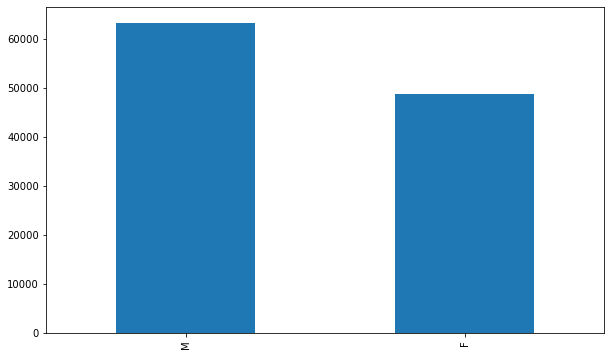

In [10]:
# Visualise gender statistics
plt.figure(figsize=(10,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

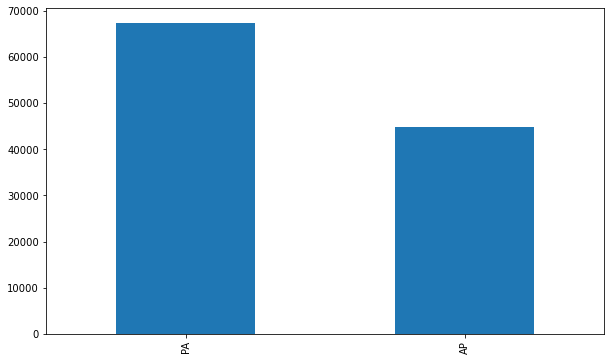

In [11]:
# Visualise view position
plt.figure(figsize=(10,6))
all_xray_df['View Position']. value_counts().plot(kind='bar')

In [12]:
# Defining all labels and number of disease per patient
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
93748  00023618_001.png     No Finding            1       23618           60   
93223  00023297_013.png     No Finding           13       23297           35   
65484  00016171_000.png      Emphysema            0       16171           70   

      Patient Gender View Position  OriginalImage[Width  Height]  \
93748              M            PA                 2500     2048   
93223              F            PA                 2992     2991   
65484              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis Hernia  \
93748                        0.168  ...        0.0       0.0    0.0   
93223                        0.143  ...        0.0       0.0    0.0   
65484                        0.143  ...        1.0       0.0    0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
93748           0.0   0.0         1.0     0.0                 0.0        0.0   
93223           0.0   0.0         1.0     0.0                 0.0        0.0   
65484           0.0   0.0         0.0     0.0                 0.0        0.0   

       Pneumothorax  
93748           0.0  
93223           0.0  
65484           0.0  

[3 rows x 28 columns]

In [11]:
# Number of pneumonia cases
len(all_xray_df[all_xray_df.Pneumonia==1])

1431

In [12]:
# Number of non-pneumonia cases
len(all_xray_df[all_xray_df.Pneumonia==0])

110689

In [17]:
# Visualize age distribution in pneumonia-only cases
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=30)
plt.xlim(0,100)

(0.0, 100.0)

In [18]:
# Visualize gender distribution in pneumonia-only cases
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

In [ ]:
# Age and gender distribution in the pneumonia-only subgroup is similar to the main population. 

[Text(0, 0.5, 'Number of Images with Label')]

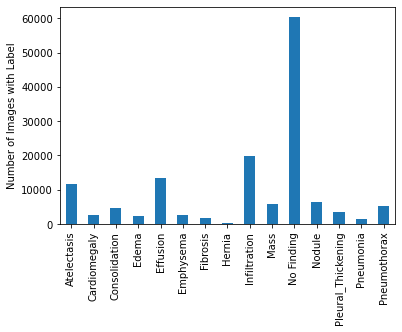

In [13]:
# Distribution of all labels
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [19]:
all_xray_df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [5]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with pneumonia and co-occur diseases')]

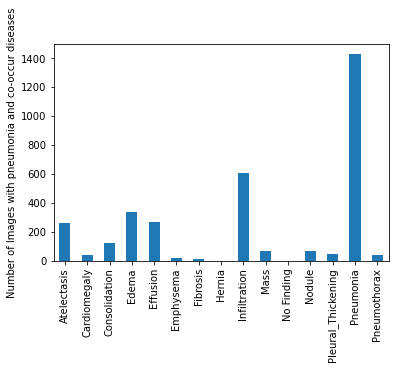

In [19]:
# Distribution of all diseases that co-occur with pneumonia
ax = all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with pneumonia and co-occur diseases')

In [20]:
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum()

Atelectasis            262.0
Cardiomegaly            41.0
Consolidation          123.0
Edema                  340.0
Effusion               269.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
No Finding               0.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Pneumothorax            41.0
dtype: float64

In [22]:
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum()/len(all_xray_df[all_xray_df.Pneumonia==1])

Atelectasis           0.183089
Cardiomegaly          0.028651
Consolidation         0.085954
Edema                 0.237596
Effusion              0.187980
Emphysema             0.016073
Fibrosis              0.007687
Hernia                0.002096
Infiltration          0.422781
Mass                  0.049616
No Finding            0.000000
Nodule                0.048917
Pleural_Thickening    0.033543
Pneumonia             1.000000
Pneumothorax          0.028651
dtype: float64

In [ ]:
# We can see that the highest co-occurrence with pneumonia is with 'Infiltration' with around 42% of cases. 

In [7]:
# Defining number of disease per patient by adding a column with the sum of all labels
all_xray_df['Disease Per Patient'] = all_xray_df[all_labels].sum(axis=1)
all_xray_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
27301   00007109_013.png     No Finding           13        7109           38   
106735  00028794_000.png   Cardiomegaly            0       28794           35   
73532   00018089_000.png     No Finding            0       18089           37   

       Patient Gender View Position  OriginalImage[Width  Height]  \
27301               F            AP                 2500     2048   
106735              F            PA                 1733     2021   
73532               F            PA                 2992     2991   

        OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia Infiltration  Mass  \
27301                      0.168000  ...       0.0     0.0          0.0   0.0   
106735                     0.194311  ...       0.0     0.0          0.0   0.0   
73532                      0.143000  ...       0.0     0.0          0.0   0.0   

        No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
27301          1.0     0.0                 0.0        0.0           0.0   
106735         0.0     0.0                 0.0        0.0           0.0   
73532          1.0     0.0                 0.0        0.0           0.0   

        Disease Per Patient  
27301                   1.0  
106735                  1.0  
73532                   1.0  

[3 rows x 29 columns]

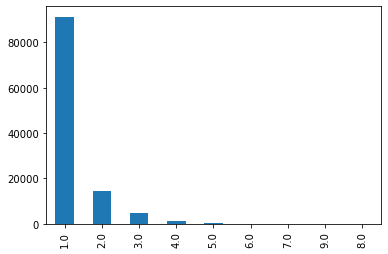

In [8]:
# Plotting number of disease per patient
all_xray_df['Disease Per Patient']. value_counts().plot(kind='bar')

In [5]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
962   00004998_000.png     No Finding            0        4998        012Y   
5288  00028504_000.png     No Finding            0       28504        060Y   
2718  00013641_013.png     No Finding           13       13641        039Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
962               M            PA                2048                 2500   
5288              F            PA                2021                 2021   
2718              M            AP                2500                 2048   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
962                      0.171000                     0.171000  
5288                     0.194311                     0.194311  
2718                     0.168000                     0.168000

In [6]:
sample_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(sample_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(sample_paths.get)
sample_df.head(3)

Scans found: 112120 , Total Headers 5606


Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y                                      path  
0                        0.139  /data/images_001/images/00000013_005.png  
1                        0.168  /data/images_001/images/00000013_026.png  
2                        0.168  /data/images_001/images/00000017_001.png

In [7]:
# Binarize labels
sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_labels = [x for x in sample_labels if len(x)>0]
print('Sample Labels ({}): {}'.format(len(sample_labels), sample_labels))
for c_label in sample_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

Sample Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
983   00005119_002.png     No Finding            2        5119        021Y   
1251  00006593_000.png     No Finding            0        6593        053Y   
5210  00027872_000.png     No Finding            0       27872        040Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
983               M            PA                2048                 2500   
1251              M            PA                2500                 2048   
5210              F            PA                2268                 2507   

      OriginalImagePixelSpacing_x  ...  Emphysema Fibrosis  Hernia  \
983                         0.171  ...        0.0      0.0     0.0   
1251                        0.171  ...        0.0      0.0     0.0   
5210                        0.143  ...        0.0      0.0     0.0   

      Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
983            0.0   0.0         1.0     0.0                 0.0        0.0   
1251           0.0   0.0         1.0     0.0                 0.0        0.0   
5210           0.0   0.0         1.0     0.0                 0.0        0.0   

      Pneumothorax  
983            0.0  
1251           0.0  
5210           0.0  

[3 rows x 27 columns]

In [7]:
# Pixel-based assessment for pneumonia
pneumonia = sample_df[sample_df.Pneumonia==1]

In [9]:
pneumonia['path']

256     /data/images_002/images/00001373_010.png
287     /data/images_002/images/00001529_004.png
382     /data/images_002/images/00001993_000.png
723     /data/images_002/images/00003789_000.png
775     /data/images_003/images/00004074_000.png
                          ...                   
5168    /data/images_011/images/00027589_001.png
5189    /data/images_011/images/00027725_073.png
5201    /data/images_011/images/00027757_002.png
5366    /data/images_012/images/00028924_005.png
5565    /data/images_012/images/00030398_000.png
Name: path, Length: 62, dtype: object

In [34]:
pneumonia = imread('/data/images_012/images/00028924_005.png')
imshow(pneumonia)

In [22]:
# In this view the right side has pneumonia and the left side has normal lung tissue
# will plot histogram to compare healthy vs disease
normal_x = [700,750]
normal_y = [300,400]
pneumonia_x = [200,250]
pneumonia_y = [600,700]
                   

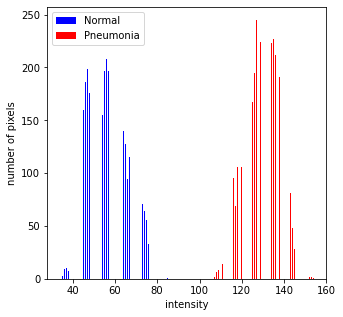

In [27]:
plt.figure(figsize=(5,5))
plt.hist(pneumonia[normal_y[0]:normal_y[1],normal_x[0]:normal_x[1]].ravel(), bins = 256, color='blue')
plt.hist(pneumonia[pneumonia_y[0]:pneumonia_y[1], pneumonia_x[0]:pneumonia_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Pneumonia'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Pixel intensity is much higher in pneumonia tissue compared to healthy lung tissue with seperation. 

In [12]:
# Pixel-based assessment of atelectasis
atelectasis = sample_df[sample_df.Atelectasis==1]
atelectasis['path']

3       /data/images_001/images/00000030_001.png
29      /data/images_001/images/00000175_001.png
30      /data/images_001/images/00000175_002.png
47      /data/images_001/images/00000248_020.png
118     /data/images_001/images/00000642_000.png
                          ...                   
5588    /data/images_012/images/00030609_021.png
5591    /data/images_012/images/00030635_007.png
5594    /data/images_012/images/00030636_013.png
5595    /data/images_012/images/00030636_014.png
5599    /data/images_012/images/00030695_002.png
Name: path, Length: 508, dtype: object

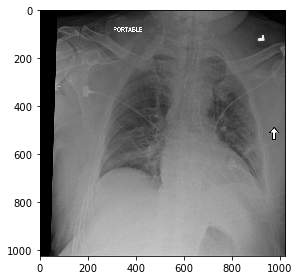

In [29]:
atelectasis = imread('/data/images_001/images/00000175_001.png')
imshow(atelectasis)

In [30]:
# In this view the right base has atelectasis and the right top is clear
# will compare right base with right apex
normal_x = [350,400]
normal_y = [300,400]
atelec_x = [350,400]
atelec_y = [600,650]

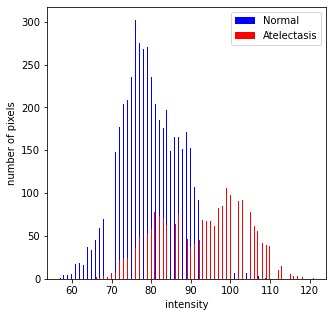

In [31]:
plt.figure(figsize=(5,5))
plt.hist(atelectasis[normal_y[0]:normal_y[1],normal_x[0]:normal_x[1]].ravel(), bins = 256, color='blue')
plt.hist(atelectasis[atelec_y[0]:atelec_y[1], atelec_x[0]:atelec_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Atelectasis'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Atelectasis pixel intensit is higher than normal lung tissue, but there is overlap between both intensities. 

In [8]:
# Pixel-based assessment of cardiomegaly
cardiomegaly = sample_df[sample_df.Cardiomegaly==1]
cardiomegaly['path']

1       /data/images_001/images/00000013_026.png
4       /data/images_001/images/00000032_001.png
19      /data/images_001/images/00000116_013.png
21      /data/images_001/images/00000116_032.png
22      /data/images_001/images/00000116_040.png
                          ...                   
5472    /data/images_012/images/00029808_003.png
5494    /data/images_012/images/00029940_007.png
5528    /data/images_012/images/00030140_000.png
5571    /data/images_012/images/00030419_001.png
5602    /data/images_012/images/00030786_005.png
Name: path, Length: 141, dtype: object

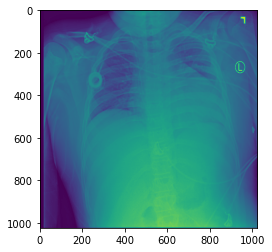

In [14]:
cardiomegaly = imread('/data/images_012/images/00030419_001.png')
plt.imshow(cardiomegaly)

(array([1.8459e+04, 3.2460e+03, 8.2190e+03, 1.0068e+04, 3.7520e+03,
        9.1800e+02, 8.2000e+02, 8.8000e+02, 9.8500e+02, 1.1120e+03,
        1.1940e+03, 1.2490e+03, 1.5040e+03, 1.6140e+03, 1.4060e+03,
        1.5200e+03, 1.8400e+03, 2.6820e+03, 3.2270e+03, 3.0320e+03,
        2.7550e+03, 2.5980e+03, 2.2420e+03, 2.2480e+03, 2.3900e+03,
        2.2970e+03, 2.0150e+03, 1.8260e+03, 1.7580e+03, 1.7180e+03,
        1.7080e+03, 1.7150e+03, 1.7510e+03, 1.6110e+03, 1.6340e+03,
        1.7040e+03, 1.7820e+03, 1.8010e+03, 1.7830e+03, 1.8350e+03,
        1.9500e+03, 2.1000e+03, 2.2420e+03, 2.3330e+03, 2.5600e+03,
        2.8120e+03, 2.9330e+03, 3.0620e+03, 3.2120e+03, 3.2060e+03,
        3.3520e+03, 3.4320e+03, 3.4710e+03, 3.8120e+03, 3.9830e+03,
        3.8240e+03, 3.9010e+03, 3.9790e+03, 4.2270e+03, 4.5680e+03,
        4.8810e+03, 5.0220e+03, 5.3570e+03, 5.4680e+03, 5.8830e+03,
        5.8960e+03, 6.2420e+03, 6.4370e+03, 6.6380e+03, 6.9630e+03,
        7.0560e+03, 7.0250e+03, 7.4430e+03, 7.47

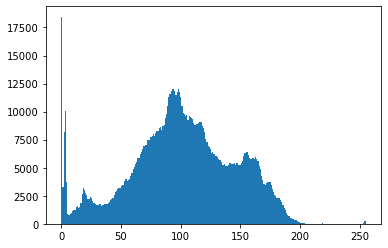

In [11]:
plt.hist(cardiomegaly.ravel(), bins=256)

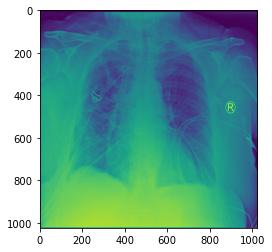

In [11]:
# Comparing with pneumonia
plt.imshow(pneumonia)

In [12]:
plt.hist(pneumonia.ravel(), bins = 256)

(array([1.1404e+04, 1.3570e+03, 5.4820e+03, 4.2420e+03, 2.3130e+03,
        1.8990e+03, 1.8540e+03, 1.4750e+03, 1.3870e+03, 1.1900e+03,
        1.1750e+03, 1.0580e+03, 1.0710e+03, 1.2520e+03, 1.1790e+03,
        1.2970e+03, 1.5550e+03, 1.3590e+03, 1.3570e+03, 1.5470e+03,
        1.2570e+03, 1.1120e+03, 9.8400e+02, 1.0780e+03, 1.2060e+03,
        1.2710e+03, 1.2410e+03, 1.3040e+03, 1.3220e+03, 1.2960e+03,
        1.3560e+03, 1.5130e+03, 1.6000e+03, 1.7410e+03, 1.7500e+03,
        1.8920e+03, 1.9260e+03, 2.1030e+03, 2.4130e+03, 2.5940e+03,
        2.9290e+03, 3.1050e+03, 3.1840e+03, 3.3300e+03, 3.5780e+03,
        3.7630e+03, 3.8590e+03, 3.7380e+03, 3.7270e+03, 3.7380e+03,
        3.5960e+03, 3.6170e+03, 3.7800e+03, 3.6570e+03, 3.8370e+03,
        3.8330e+03, 3.9330e+03, 3.7610e+03, 3.7330e+03, 3.6910e+03,
        3.7470e+03, 3.7330e+03, 3.5990e+03, 3.6740e+03, 3.6250e+03,
        3.6200e+03, 3.6860e+03, 3.6870e+03, 3.8800e+03, 4.0000e+03,
        4.1540e+03, 4.2550e+03, 4.2530e+03, 4.56

In [15]:
# Segmentation
thresh = 100
cardiomegaly_bin = (cardiomegaly>thresh) * 255
pneumonia_bin = (pneumonia>thresh) * 255

In [16]:
plt.imshow(cardiomegaly_bin)

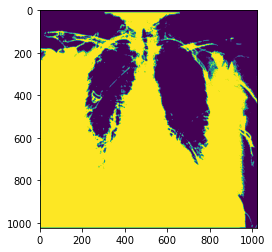

In [17]:
plt.imshow(pneumonia_bin)

In [18]:
cardiomegaly = sample_df[sample_df.Cardiomegaly==1]
pneumonia = sample_df[sample_df.Pneumonia==1]


In [24]:
# Plotting pixel intensity for cardiomegaly images in sample_df
cardiomegaly_intensities = []
for i in cardiomegaly['path']:
    img = imread(i)
    img_mask = img>thresh
    cardiomegaly_intensities.extend(img[img_mask].tolist())
    

In [29]:
plt.hist(cardiomegaly_intensities, bins =256)

(array([ 748262.,  751783.,       0.,  758796.,  760230.,       0.,
         763748.,       0.,  772568.,  780574.,       0.,  790267.,
              0.,  803168.,  811454.,       0.,  820553.,       0.,
         821227.,  823016.,       0.,  827453.,       0.,  835482.,
         838798.,       0.,  844437.,       0.,  848684.,  853549.,
              0.,  856175.,       0.,  859393.,  863526.,       0.,
         865269.,       0.,  869532.,  872309.,       0.,  875620.,
              0.,  876491.,  878330.,       0.,  876333.,       0.,
         874670.,  877013.,       0.,  879062.,       0.,  880391.,
         882491.,       0.,  880112.,       0.,  886635.,  892046.,
              0.,  900483.,       0.,  912962.,  932015.,       0.,
         944505.,       0.,  948325.,  936136.,       0.,  917199.,
              0.,  891614.,  864883.,       0.,  837003.,       0.,
         811869.,  795520.,       0.,  780240.,       0.,  764506.,
         751489.,       0.,  742738.,       0., 

In [19]:
# Plotting signal intensity for pneumonia images in sample_df
pneumonia_intensities = []
for i in pneumonia['path']:
    img = imread(i)
    img_mask = img>thresh
    pneumonia_intensities.extend(img[img_mask].tolist())

In [20]:
plt.hist(pneumonia_intensities, bins =256)

(array([ 309506.,  314465.,       0.,  317674.,  321421.,       0.,
         326754.,       0.,  332295.,  338388.,       0.,  344717.,
              0.,  350732.,  355647.,       0.,  361595.,       0.,
         365708.,  367234.,       0.,  368935.,       0.,  370787.,
         373214.,       0.,  375964.,       0.,  376654.,  379366.,
              0.,  380169.,       0.,  383844.,  383913.,       0.,
         383640.,       0.,  384717.,  384349.,       0.,  384136.,
              0.,  384598.,  386781.,       0.,  388195.,       0.,
         392217.,  393058.,       0.,  394562.,       0.,  395067.,
         395602.,       0.,  396909.,       0.,  399507.,  399258.,
              0.,  401120.,       0.,  401598.,  401470.,       0.,
         401529.,       0.,  404700.,  408893.,       0.,  412352.,
              0.,  409086.,  405472.,       0.,  399730.,       0.,
         394648.,  389418.,       0.,  388187.,       0.,  388266.,
         389267.,       0.,  390550.,       0., 

In [27]:
# Apart from the different sample size (larger pneumonia class), there is no significant difference in pixel intensity distribution between cardiomegaly and pneumonia


In [28]:
# Pixel-based assessment of consolidation
consolidation = sample_df[sample_df.Consolidation==1]
consolidation['path']

5       /data/images_001/images/00000040_003.png
10      /data/images_001/images/00000061_025.png
19      /data/images_001/images/00000116_013.png
20      /data/images_001/images/00000116_019.png
21      /data/images_001/images/00000116_032.png
                          ...                   
5534    /data/images_012/images/00030167_001.png
5559    /data/images_012/images/00030346_001.png
5565    /data/images_012/images/00030398_000.png
5568    /data/images_012/images/00030410_002.png
5593    /data/images_012/images/00030636_012.png
Name: path, Length: 226, dtype: object

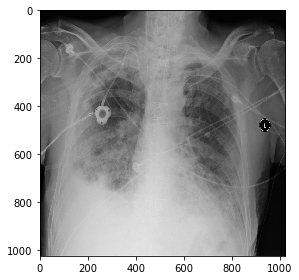

In [29]:
consolidation= imread('/data/images_001/images/00000061_025.png')
imshow(consolidation)

In [30]:
# In this view the consolidation in the right basal lung field
# will compare pixel distribution in consolidation to healthy lung on the left
normal_x = [700,800]
normal_y = [500,600]
consolidation_x = [100,200]
consolidation_y = [700,800]

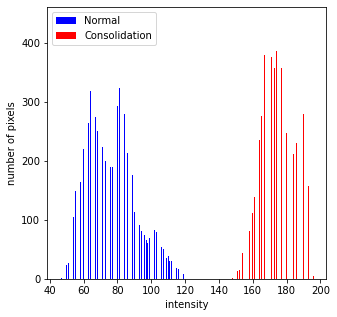

In [29]:
plt.figure(figsize=(5,5))
plt.hist(consolidation[normal_y[0]:normal_y[1],normal_x[0]:normal_x[1]].ravel(), bins = 256, color='blue')
plt.hist(consolidation[consolidation_y[0]:consolidation_y[1], consolidation_x[0]:consolidation_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Consolidation'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# There is a higher signal intensity in consolidation compared to healthy lung tissue, similar pattern to pneumonia

In [31]:
# Pixel-based assessment of edema
edema = sample_df[sample_df.Edema==1]
edema['path']

4       /data/images_001/images/00000032_001.png
203     /data/images_001/images/00001106_000.png
225     /data/images_001/images/00001249_002.png
243     /data/images_001/images/00001301_020.png
282     /data/images_002/images/00001504_009.png
                          ...                   
5140    /data/images_011/images/00027355_009.png
5190    /data/images_011/images/00027726_003.png
5204    /data/images_011/images/00027782_002.png
5308    /data/images_012/images/00028579_005.png
5353    /data/images_012/images/00028873_006.png
Name: path, Length: 118, dtype: object

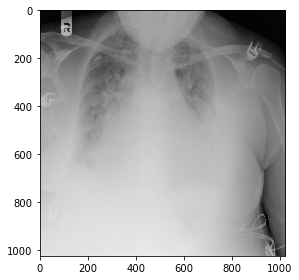

In [32]:
edema = imread('/data/images_001/images/00000032_001.png')
imshow(edema)

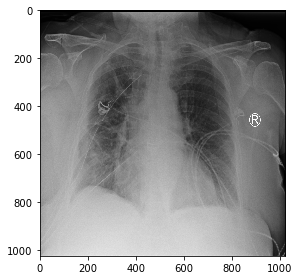

In [35]:
imshow(pneumonia)

In [36]:
# Will compare tissues with oedema (top x-ray) to normal lung tissue (bottom x-ray in the left lung)
normal_x = [700,800]
normal_y = [400,500]
edema_x = [150,200]
edema_y = [550,600]

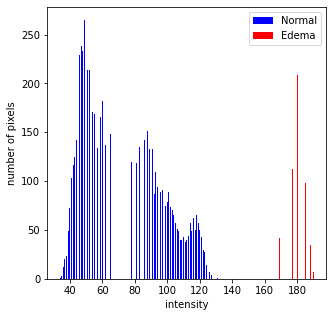

In [37]:
plt.figure(figsize=(5,5))
plt.hist(pneumonia[normal_y[0]:normal_y[1],normal_x[0]:normal_x[1]].ravel(), bins = 256, color='blue')
plt.hist(edema[edema_y[0]:edema_y[1], edema_x[0]:edema_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Edema'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Edema has higher pixel intensity compared to healthy lung with seperation (similar to pneumonia) but has less number of pixels (more disperse)

In [38]:
# Pixel-based assessment of effusion
effusion = sample_df[sample_df.Effusion==1]
effusion['path']

4       /data/images_001/images/00000032_001.png
8       /data/images_001/images/00000061_002.png
10      /data/images_001/images/00000061_025.png
14      /data/images_001/images/00000084_000.png
15      /data/images_001/images/00000096_006.png
                          ...                   
5590    /data/images_012/images/00030635_002.png
5591    /data/images_012/images/00030635_007.png
5594    /data/images_012/images/00030636_013.png
5595    /data/images_012/images/00030636_014.png
5602    /data/images_012/images/00030786_005.png
Name: path, Length: 644, dtype: object

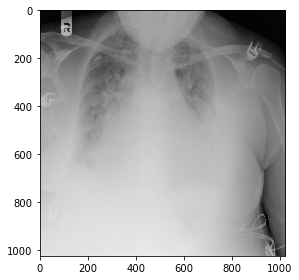

In [39]:
effusion = imread('/data/images_001/images/00000032_001.png')
imshow(effusion)

In [42]:
# Will compare the fluid area (effusion area) with lung tissue area
lung_x = [200,300]
lung_y = [200,350]
effusion_x = [500,700]
effusion_y = [500,700]

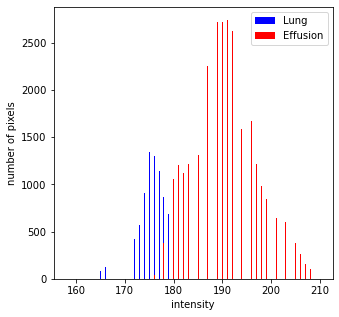

In [43]:
plt.figure(figsize=(5,5))
plt.hist(effusion[normal_y[0]:normal_y[1],normal_x[0]:normal_x[1]].ravel(), bins = 256, color='blue')
plt.hist(effusion[effusion_y[0]:effusion_y[1], effusion_x[0]:effusion_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Lung', 'Effusion'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Effusion pixel intensity is higher than lung tissue and has mild overlap

In [8]:
# Pixel-based assessment of emphysema
emphysema = sample_df[sample_df.Emphysema==1]

In [9]:
emphysema['path']

0       /data/images_001/images/00000013_005.png
1       /data/images_001/images/00000013_026.png
41      /data/images_001/images/00000243_001.png
61      /data/images_001/images/00000359_002.png
67      /data/images_001/images/00000376_007.png
                          ...                   
5475    /data/images_012/images/00029813_009.png
5476    /data/images_012/images/00029813_031.png
5496    /data/images_012/images/00029950_014.png
5500    /data/images_012/images/00029981_002.png
5602    /data/images_012/images/00030786_005.png
Name: path, Length: 127, dtype: object

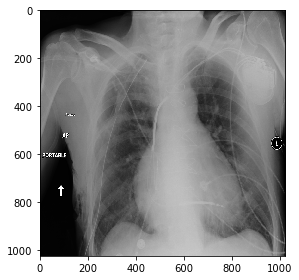

In [18]:
emphysema=imread('/data/images_001/images/00000013_026.png')
imshow(emphysema)

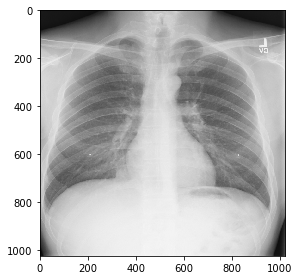

In [14]:
# Visualise healthy lung tissue
imshow(img)

In [15]:
# Will compare emphysema lung tissue with healthy lung pixel intensity
healthy_x = [100,200]
healthy_y = [500,600]
emphysema_x = [250,350]
emphysema_y = [600,700]

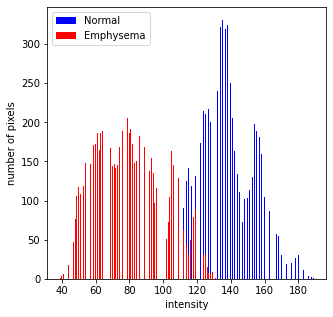

In [19]:
plt.figure(figsize=(5,5))
plt.hist(img[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(emphysema[emphysema_y[0]:emphysema_y[1], emphysema_x[0]:emphysema_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Emphysema'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Pixel intensity in emphysema lung disease is less than normal lung

In [10]:
# Pixel-based assessment of fibrosis
fibrosis = sample_df[sample_df.Fibrosis==1]

In [11]:
fibrosis['path']

31      /data/images_001/images/00000181_001.png
38      /data/images_001/images/00000232_000.png
89      /data/images_001/images/00000508_000.png
91      /data/images_001/images/00000524_001.png
96      /data/images_001/images/00000545_004.png
                          ...                   
4708    /data/images_010/images/00024012_000.png
4990    /data/images_011/images/00026336_001.png
5144    /data/images_011/images/00027394_000.png
5269    /data/images_012/images/00028317_012.png
5487    /data/images_012/images/00029880_012.png
Name: path, Length: 84, dtype: object

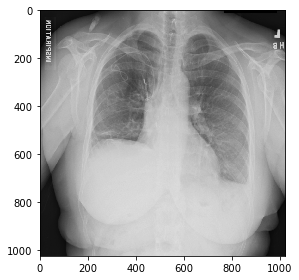

In [12]:
fibrosis = imread('/data/images_001/images/00000181_001.png')
imshow(fibrosis)

In [14]:
# Will compare fibrosis with normal lung tissue
healthy_x = [100,200]
healthy_y = [500,600]
fibrosis_x = [750,850]
fibrosis_y = [600,700]

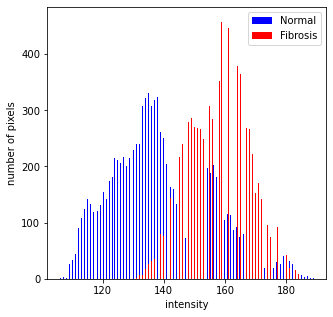

In [15]:
plt.figure(figsize=(5,5))
plt.hist(img[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(fibrosis[fibrosis_y[0]:fibrosis_y[1], fibrosis_x[0]:fibrosis_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Fibrosis'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Fibrosis has higher pixel signal intensity compared to normal lung

In [16]:
# Pixel-based assessment of hernia
hernia = sample_df[sample_df.Hernia==1]

In [17]:
hernia['path']

1254    /data/images_004/images/00006624_002.png
1418    /data/images_004/images/00007352_000.png
1479    /data/images_004/images/00007712_002.png
1544    /data/images_004/images/00008010_000.png
1546    /data/images_004/images/00008015_000.png
1662    /data/images_004/images/00008694_002.png
1775    /data/images_005/images/00009368_008.png
1852    /data/images_005/images/00009759_002.png
2546    /data/images_006/images/00012833_000.png
2574    /data/images_006/images/00012905_000.png
2752    /data/images_007/images/00013791_000.png
3381    /data/images_008/images/00016672_003.png
3692    /data/images_008/images/00018120_001.png
Name: path, dtype: object

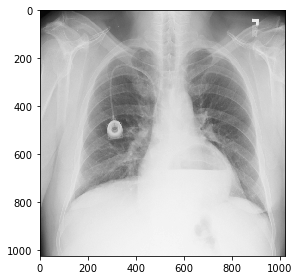

In [19]:
hernia = imread('/data/images_004/images/00007352_000.png')
imshow(hernia)

In [32]:
# Will compare the cardiac sillouette with and without hernia from (hernia vs img)
no_hernia_x = [400,700]
no_hernia_y = [600,700]
hernia_x = [400,700]
hernia_y = [600,700]

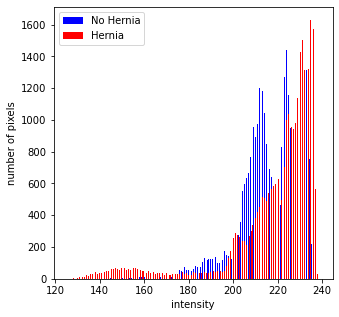

In [33]:
plt.figure(figsize=(5,5))
plt.hist(img[no_hernia_y[0]:no_hernia_y[1],no_hernia_x[0]:no_hernia_x[1]].ravel(), bins = 256, color='blue')
plt.hist(hernia[hernia_y[0]:hernia_y[1], hernia_x[0]:hernia_x[1]].ravel(), bins = 256, color='red')
plt.legend(['No Hernia', 'Hernia'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# There is overlap in pixel intensity, but the presence of hernia increases the intensity.

In [9]:
# Pixel-based assessment of infiltration
infiltration = sample_df[sample_df.Infiltration==1]

In [10]:
infiltration['path']

0       /data/images_001/images/00000013_005.png
10      /data/images_001/images/00000061_025.png
27      /data/images_001/images/00000154_001.png
32      /data/images_001/images/00000181_017.png
33      /data/images_001/images/00000181_035.png
                          ...                   
5585    /data/images_012/images/00030573_013.png
5588    /data/images_012/images/00030609_021.png
5591    /data/images_012/images/00030635_007.png
5598    /data/images_012/images/00030650_002.png
5603    /data/images_012/images/00030789_000.png
Name: path, Length: 967, dtype: object

In [14]:
infiltration = imread('/data/images_001/images/00000154_001.png')
imshow(infiltration)

In [17]:
# Will compare infiltration from right lung to normal lung in img
healthy_x = [100,200]
healthy_y = [500,600]
infiltration_x = [200,300]
infiltration_y = [500,600]

In [18]:
plt.figure(figsize=(5,5))
plt.hist(img[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(infiltration[infiltration_y[0]:infiltration_y[1], infiltration_x[0]:infiltration_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Infiltration'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Pixel intensity has global overlap between infiltration and normal lung

In [19]:
# Pixel-based assessment of mass
mass = sample_df[sample_df.Mass==1]

In [20]:
mass['path']

5       /data/images_001/images/00000040_003.png
11      /data/images_001/images/00000079_000.png
18      /data/images_001/images/00000103_001.png
45      /data/images_001/images/00000246_016.png
47      /data/images_001/images/00000248_020.png
                          ...                   
5499    /data/images_012/images/00029976_011.png
5507    /data/images_012/images/00030045_000.png
5532    /data/images_012/images/00030159_000.png
5533    /data/images_012/images/00030159_015.png
5538    /data/images_012/images/00030183_004.png
Name: path, Length: 284, dtype: object

In [21]:
mass = imread('/data/images_001/images/00000040_003.png')

In [22]:
imshow(mass)

In [25]:
# Will compare the mass in the left mid zone to healhty lung in the right side
mass_x = [750,850]
mass_y = [300,400]
healthy_x = [200,300]
healthy_y = [400,500]

In [26]:
plt.figure(figsize=(5,5))
plt.hist(mass[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(mass[mass_y[0]:mass_y[1], mass_x[0]:mass_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Mass'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Pixel intensity of the mass is much higher than healthy lung

In [27]:
# Pixel-based assessment of nodule
nodule = sample_df[sample_df.Nodule==1]
nodule['path']

10      /data/images_001/images/00000061_025.png
27      /data/images_001/images/00000154_001.png
59      /data/images_001/images/00000324_001.png
100     /data/images_001/images/00000556_000.png
101     /data/images_001/images/00000569_005.png
                          ...                   
5449    /data/images_012/images/00029617_007.png
5454    /data/images_012/images/00029678_001.png
5482    /data/images_012/images/00029852_002.png
5518    /data/images_012/images/00030079_049.png
5554    /data/images_012/images/00030301_000.png
Name: path, Length: 313, dtype: object

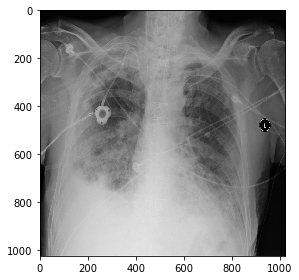

In [28]:
nodule = imread('/data/images_001/images/00000061_025.png')
imshow(nodule)

In [29]:
# Will compare nodules in the right side with healthy lung from previous image 
nodule_x = [200,300]
nodule_y = [600,650]
healthy_x = [200,300]
healthy_y = [400,500]

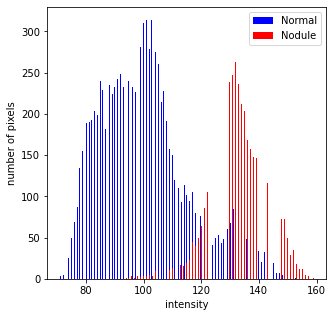

In [30]:
plt.figure(figsize=(5,5))
plt.hist(mass[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(nodule[nodule_y[0]:nodule_y[1], nodule_x[0]:nodule_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Nodule'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# Pixel signal intensity is higher for nodule compared to healthy lung

In [31]:
# Pixel-based assessment of pleural thickening
pl_thick = sample_df[sample_df.Pleural_Thickening==1]
pl_thick['path']

0       /data/images_001/images/00000013_005.png
26      /data/images_001/images/00000132_002.png
47      /data/images_001/images/00000248_020.png
91      /data/images_001/images/00000524_001.png
102     /data/images_001/images/00000580_001.png
                          ...                   
5475    /data/images_012/images/00029813_009.png
5482    /data/images_012/images/00029852_002.png
5495    /data/images_012/images/00029943_034.png
5501    /data/images_012/images/00029981_006.png
5503    /data/images_012/images/00029998_010.png
Name: path, Length: 176, dtype: object

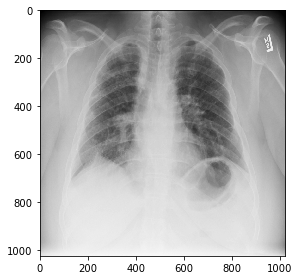

In [35]:
pl_thick = imread('/data/images_001/images/00000524_001.png')
imshow(pl_thick)

In [44]:
# Will compare pleural thickening in right mid zone with healthy lung in the left. 
healthy_x = [700, 800]
healthy_y = [300, 400]
pl_thick_x = [300, 400]
pl_thick_y = [400, 500]

In [45]:
plt.figure(figsize=(5,5))
plt.hist(pl_thick[healthy_y[0]:healthy_y[1],healthy_x[0]:healthy_x[1]].ravel(), bins = 256, color='blue')
plt.hist(pl_thick[pl_thick_y[0]:pl_thick_y[1], pl_thick_x[0]:pl_thick_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Pleural Thickening'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
# There is overlap in pixel intensity between pleural thickening and healthy lung, but peak intensity is higher in pleural thikening (around 140) compared to healthy lung (around 70)

In [47]:
# Pixel-based assessment of pneumothorax
pneumothorax = sample_df[sample_df.Pneumothorax==1]
pneumothorax['path']

0       /data/images_001/images/00000013_005.png
18      /data/images_001/images/00000103_001.png
23      /data/images_001/images/00000118_011.png
66      /data/images_001/images/00000372_002.png
80      /data/images_001/images/00000467_013.png
                          ...                   
5590    /data/images_012/images/00030635_002.png
5592    /data/images_012/images/00030636_010.png
5594    /data/images_012/images/00030636_013.png
5595    /data/images_012/images/00030636_014.png
5598    /data/images_012/images/00030650_002.png
Name: path, Length: 271, dtype: object

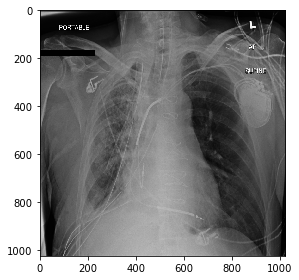

In [48]:
pneumo = imread('/data/images_001/images/00000013_005.png')
imshow(pneumo)

In [49]:
# Will compare pneumothorax pixel intensity from left lung to right lung
pneumo_x = [700, 800]
pneumo_y = [400, 500]
no_pneumo_x = [300, 350]
no_pneumo_y = [400, 450]

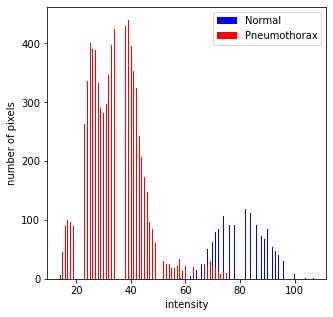

In [50]:
plt.figure(figsize=(5,5))
plt.hist(pneumo[no_pneumo_y[0]:no_pneumo_y[1],no_pneumo_x[0]:no_pneumo_x[1]].ravel(), bins = 256, color='blue')
plt.hist(pneumo[pneumo_y[0]:pneumo_y[1], pneumo_x[0]:pneumo_x[1]].ravel(), bins = 256, color='red')
plt.legend(['Normal', 'Pneumothorax'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

In [ ]:
#Pixel signal intensity is much lower for pneumothorax compared to lung tissue. 